# UBER Supply Demand Gap 

## Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Reading the Data File

In [2]:
df = pd.read_csv("./Uber Request Data.csv")
df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


## Checking the data types of the variables in the file

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
Request id           6745 non-null int64
Pickup point         6745 non-null object
Driver id            4095 non-null float64
Status               6745 non-null object
Request timestamp    6745 non-null object
Drop timestamp       2831 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 316.2+ KB


## Check for any duplicates in the "Request ID" column as this column should be a considered for Unique entry

#### There are no duplicates in the "Request ID" column

In [4]:
df["Request id"].duplicated().any()

False

## Change the "Request" and "Drop" time stamp data from object to "Date Time" format

In [5]:
df["Request timestamp"] = pd.to_datetime(df["Request timestamp"]).dt.strftime('%d-%m-%Y %H:%M')
df["Drop timestamp"] = pd.to_datetime(df["Drop timestamp"]).dt.strftime('%d-%m-%Y %H:%M')

## Creating "Derived" metrics using the "Request timestamp" metric for generating more insights

In [6]:
df["Month"] = pd.DatetimeIndex(df["Request timestamp"]).month
df["Day"] = pd.DatetimeIndex(df["Request timestamp"]).day
df["Year"] = pd.DatetimeIndex(df["Request timestamp"]).year
df["Request Time"] = pd.DatetimeIndex(df["Request timestamp"]).time
df["Request Hour"] = pd.DatetimeIndex(df["Request timestamp"]).hour
df["Request Min"] = pd.DatetimeIndex(df["Request timestamp"]).minute
df["Drop Time"] = pd.DatetimeIndex(df["Drop timestamp"]).time
df["Drop Hour"] = pd.DatetimeIndex(df["Drop timestamp"]).hour
df["Drop Min"] = pd.DatetimeIndex(df["Drop timestamp"]).minute

## Creating "Segments" using the "Request Hour" for better analysis

In [7]:
df["Day Type"] = np.nan
df.loc[(df["Request Hour"] >= 0) & (df["Request Hour"] <= 5), 'Day Type'] = 'Early Morning'
df.loc[(df["Request Hour"] > 5) & (df["Request Hour"] <= 10), 'Day Type'] = 'Morning Peak'
df.loc[(df["Request Hour"] > 10) & (df["Request Hour"] <= 17), 'Day Type'] = 'Day Time'
df.loc[(df["Request Hour"] > 17) & (df["Request Hour"] <= 22), 'Day Type'] = 'Evening Peak'
df.loc[(df["Request Hour"] > 22) & (df["Request Hour"] <= 23), 'Day Type'] = 'Late Night'

## Plotting as grouped bar graph using the "Trip Status" and "Request Hour" data

### The below plot shows the 2 major problems UBER faces: Cancellations and Unavailability of Cabs 
1. Of the overall trips, only 42% of the Trips were completed succesfully. 39% of the requests were not fulfilled due to non availability of cars and 19% of the trips were "Cancelled".
1. Majority of the "Cancellation" occurs in the "Morning Peak" time slot, which is between 5AM to 9AM
2. Non availability of cars occured the most in the "Evening Peak" time slot which is between 5PM to 10PM

Status
Cancelled            19.0
No Cars Available    39.0
Trip Completed       42.0
dtype: float64

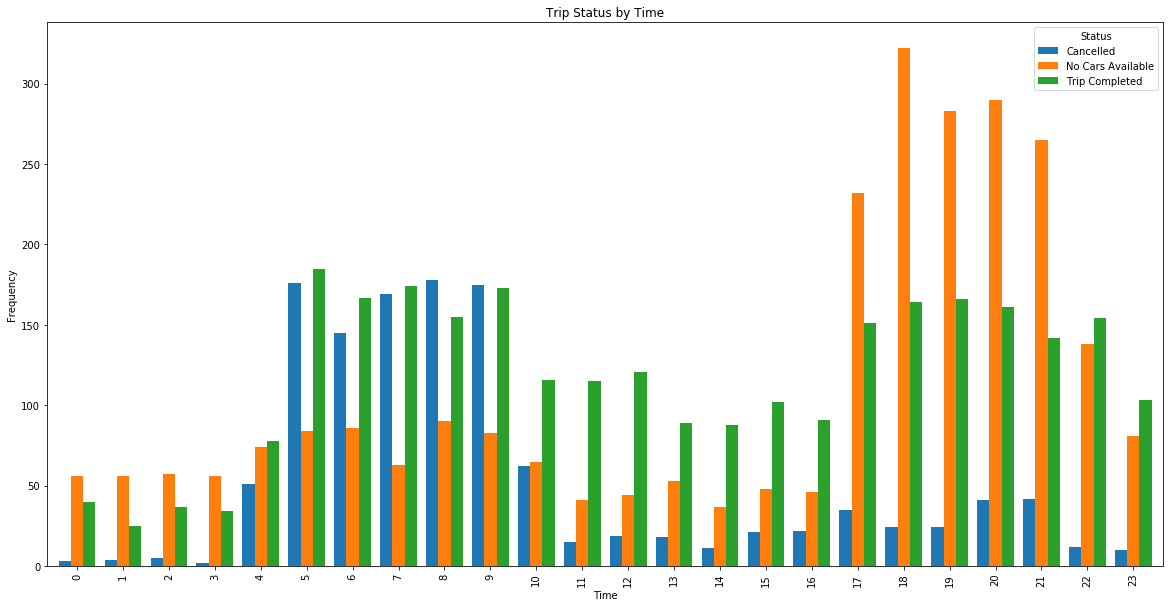

In [8]:
plot1= df.groupby(['Status','Request Hour'])['Status'].count().unstack(0).plot.bar(title="Trip Status by Time", figsize=(20,10),width=0.8)
plot1.set_xlabel("Time")
plot1.set_ylabel("Frequency")
round(df.groupby("Status").size()/df["Status"].count()*100)

### The below plot shows that the:
1. 48% of the overall trip is from Airport to City and 52% of the trips is from City to Airport
2. Majority of the trip requests in the "Morning Peak" time slot were from the City to Airport and that's where most number of "Cancellations" occur.
3. Also, in the "Evening Peak" time slot, most of the requests were from Airport to City.During this time, there were no sufficient Cars available to meet the demand.

Pickup point
Airport    48.0
City       52.0
dtype: float64

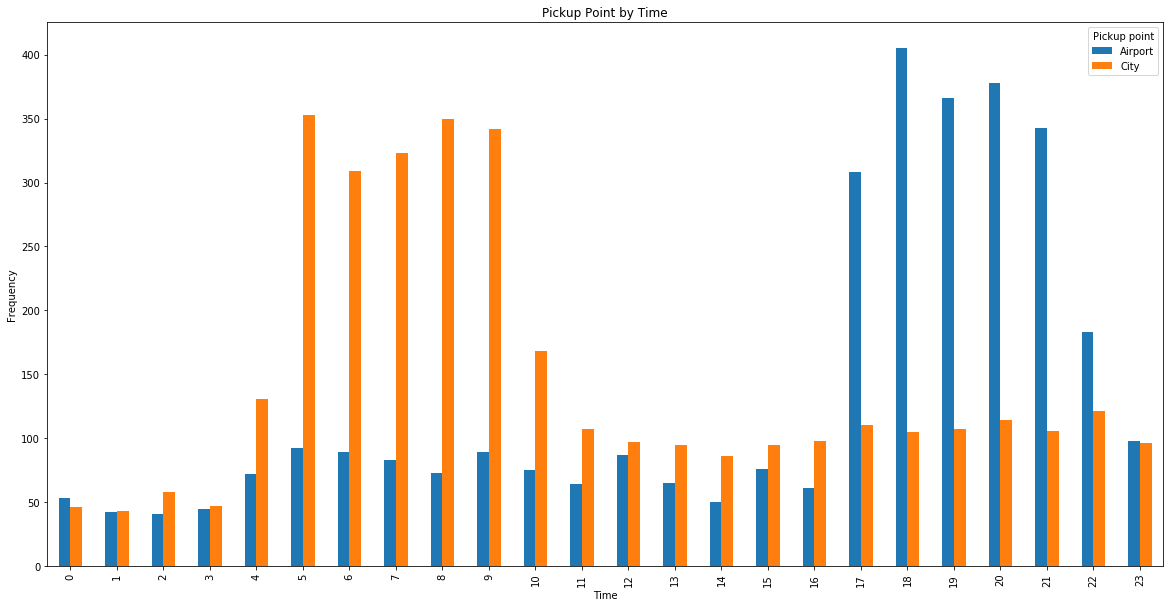

In [9]:
plot2= df.groupby(['Pickup point','Request Hour'])['Pickup point'].count().unstack(0).plot.bar(title="Pickup Point by Time", figsize=(20,10),stacked = False)
plot2.set_xlabel("Time")
plot2.set_ylabel("Frequency")
round(df.groupby("Pickup point").size()/df["Pickup point"].count()*100)

### The below plot also shows clearly that the "Cancellation" occurs mostly in the "Morning Peak" time slot and "No Cars Available" in the "Evening Peak" time slot.

Morning Peak: Of the total 1,901 Requests, 729 trips were "Cancelled", Cars were not available for 387 trip requests and 785 trips were completed

Evening Peak: Of the total 2,228 Requests, 143 trips were "Cancelled", Cars were not available for 1,298 trip requests and 787 trips were completed

Day Type       Status           
Day Time       Cancelled             141
               No Cars Available     501
               Trip Completed        757
Early Morning  Cancelled             241
               No Cars Available     383
               Trip Completed        399
Evening Peak   Cancelled             143
               No Cars Available    1298
               Trip Completed        787
Late Night     Cancelled              10
               No Cars Available      81
               Trip Completed        103
Morning Peak   Cancelled             729
               No Cars Available     387
               Trip Completed        785
dtype: int64

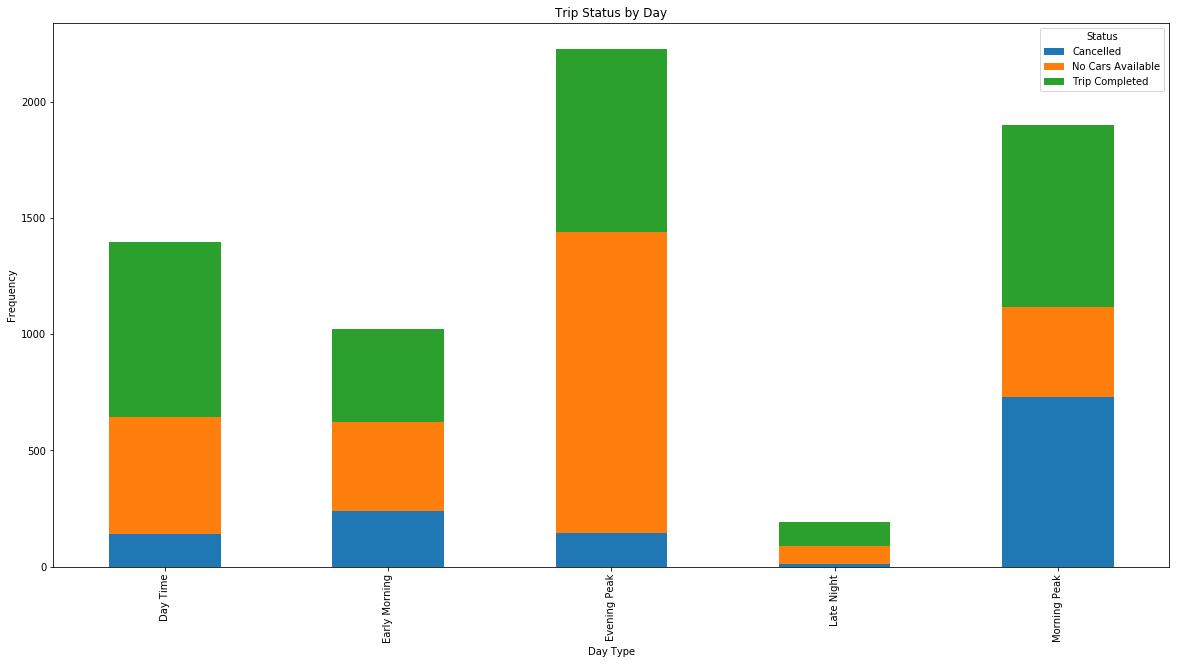

In [10]:
plot3= df.groupby(['Status','Day Type'])['Status'].count().unstack(0).plot.bar(title="Trip Status by Day", figsize=(20,10),stacked = True)
plot3.set_xlabel("Day Type")
plot3.set_ylabel("Frequency")
df.groupby(["Day Type","Status"]).size()

## Creating a Dataframe with "Morning" and "Evening" data for finding the Supply & Demand gap

## Morning Peak Hour:
1. 78% of the trip requets are from City to Airport, and 22% are from Airport to City
2. Of the total Demand of 1,492 requests made from the City, Supply was only for 435 requests. i.e Only 29.2% of the Demand was fulfilled. 47% of requests was "Cancelled" and 24% was not fulfilled due to unavailability of Cars.

Day Type      Pickup point  Status           
Morning Peak  Airport       Cancelled             28
                            No Cars Available     31
                            Trip Completed       350
              City          Cancelled            701
                            No Cars Available    356
                            Trip Completed       435
dtype: int64

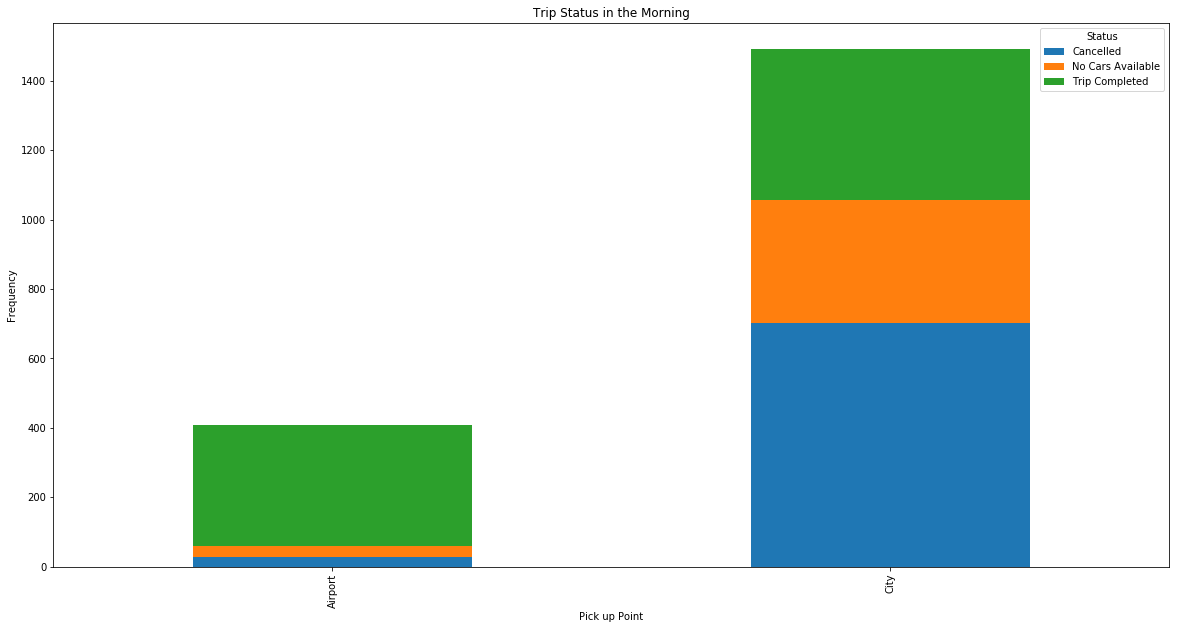

In [12]:
morning_df = df.loc[df["Day Type"] == "Morning Peak"]
evening_df = df.loc[df["Day Type"] == "Evening Peak"]
plot6= morning_df.groupby(['Status','Pickup point'])['Status'].count().unstack(0).plot.bar(title="Trip Status in the Morning", figsize=(20,10),stacked = True)
plot6.set_xlabel("Pick up Point")
plot6.set_ylabel("Frequency")
morning_df.groupby(["Day Type","Pickup point","Status"]).size()

### Reason for "Cancellations":

As we noticed above, only 29.2% of the demad is fulfilled in the Morning and almost 70% of the demand is not met. This is primarily due to the "Cancellation" of requests. Almost 47% of the demand is not fulfilled due to "Cancellation". The issue is mainly related to the huge gap between the timing of incoming and outgoing flights at the airport.
 
During the Morning peak hours between 5 AM to 9 AM, there were not many incoming flights at the airport. Most of the flights are outgoing. Hence, if the driver fulfills the demand in the Morning, he/she will have to wait for a long time at the Airport to get a customer. During this wait time, the driver could have handled few requests, had he/she was in the city.

This is why we see a lot of "Cancellations" happen in the Morning peak hours.

## Recommendations:
    1. Reward the Drivers who fulfill the trips to Airports through "Reward Points" which they can redeem at a regular interval.
    2. UBER can reduce their Commission/Charges for the trips to Airports made during the Morning peak hours. This can motivate the drivers to fufill the requests and UBER can also generate some revenues.
    3. UBER can increase the fare for the trips to airports during the Morning peak hours. This will also helps the Driver to take such trips rather than cancelling it.

## Evening Peak Hour:
1. 75% of the trip requets are from Airport to City, and 25% are from City to Airport
2. Of the total Demand of 2,228 requests, Supply was only for 787 requests. i.e Only 35% of the Demand was fulfilled.
   6% of requests was "Cancelled" and 58% was not fulfilled due to unavailability of Cars.

Day Type      Pickup point  Status           
Evening Peak  Airport       Cancelled              90
                            No Cars Available    1206
                            Trip Completed        379
              City          Cancelled              53
                            No Cars Available      92
                            Trip Completed        408
dtype: int64

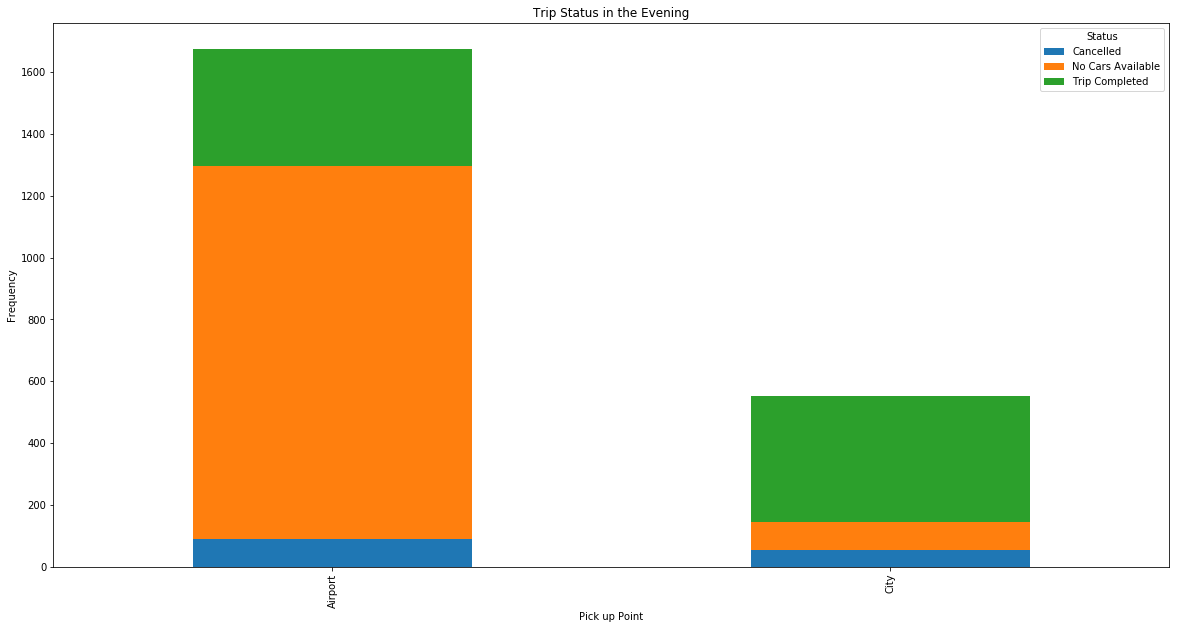

In [13]:
plot7= evening_df.groupby(['Status','Pickup point'])['Status'].count().unstack(0).plot.bar(title="Trip Status in the Evening", figsize=(20,10),stacked = True)
plot7.set_xlabel("Pick up Point")
plot7.set_ylabel("Frequency")
evening_df.groupby(["Day Type","Pickup point","Status"]).size()

### Reason for "Non avilability of Cars":

As we noticed above, only 35% of the demand is fulfilled in the Evening and almost 65% of the demand is not met. This is primarily due to the "Unavailability of Cars" during that time. Almost 58% of the demand is not fulfilled due to "Non availability of Cars". The issue is mainly related to the huge gap between the timing of incoming and outgoing flights at the airport.
 
During the Evening peak hours between 5 PM to 10 PM, there were not many outgoing flights at the airport. Most of the flights are incoming. Since there were not much of requests from City to Airport during the evening peak time, there were less cabs available in the airport to meed the huge demand.

Hence, we see a huge number of requests that are not fulfilled, due to non availability of Cars.

## Recommendations:
    1. Reward the Drivers who fulfill the trips from Airport through "Reward Points" which they can redeem at a regular interval.
    2. UBER can reduce their Commission/Charges for the trips made from the Airports during the Evening peak hours. This can motivate the drivers to fufill the requests and UBER can also generate some revenues.
    3. UBER can increase the fare for the trips to airports during the Evening peak hours. This will also helps the Driver to take such trips rather than cancelling it.

In [15]:
df.to_csv("Dataset.csv",index = False)